In [1]:
# Author：Sugulu
# Date：created 11月12日2017年
# のび太FX第3話　線形回帰モデルでFX予測1　

# 一度変数を初期化しておきます「yを押してenterしてください」
%reset 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# import関連
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # 実行上問題ない注意は非表示にする

%matplotlib inline

In [3]:
# dataフォルダの場所を各自指定してください
data_dir = "./"
data = pd.read_csv(data_dir + "USDJPY_1997_2017.csv") # FXデータの読み込み（データは同じリポジトリのdataフォルダに入っています）
data.head() # データの概要を見てみます

,Date,Open,High,Low,Close
0,1997/1/2,115.85,116.20,115.28,115.60
1,1997/1/3,115.65,116.70,115.35,116.28
2,1997/1/6,116.75,116.98,115.38,115.75
3,1997/1/7,115.74,116.02,114.80,115.25
4,1997/1/8,115.22,116.00,114.90,115.73


In [4]:
# pandasのDataFrameのままでは、扱いにくい+実行速度が遅いので、numpyに変換して処理します
data2 = np.array(data)

In [5]:
# データの内容を見ます
#data_show=pd.DataFrame(data2)
#data_show

In [6]:
# 説明変数となる行列Xを作成します
day_ago = 25 # 何日前までのデータを使用するのかを設定
num_sihyou = 1 # 終値

X = np.zeros((len(data2), day_ago*num_sihyou)) 

# 終値をfor文でday_ago日前まで一気に追加する
for i in range(0, day_ago):
    X[i:len(data2),i] = data2[0:len(data2)-i,4]

In [7]:
# Xの確認です
#data_show = pd.DataFrame(X)
#data_show

In [8]:
# 被説明変数となる Y = pre_day後の終値-当日終値 を作成します
Y = np.zeros(len(data2))

# 何日後を値段の差を予測するのか決めます
pre_day = 1
Y[0:len(Y)-pre_day] = X[pre_day:len(X),0] - X[0:len(X)-pre_day,0]

In [9]:
# 【重要】X, Yを正規化します
original_X = np.copy(X) # コピーするときは、そのままイコールではダメ
tmp_mean = np.zeros(len(X))

for i in range(day_ago,len(X)):
    tmp_mean[i] = np.mean(original_X[i-day_ago+1:i+1,0]) # 25日分の平均値
    for j in range(0, X.shape[1]): 
        X[i,j] = (X[i,j] - tmp_mean[i]) # Xを正規化
    Y[i] =  Y[i]  # X同士の引き算しているので、Yはそのまま

In [10]:
# 平均の確認です
#data_show = pd.DataFrame(tmp_mean)
#data_show

In [11]:
# XとYを学習データとテストデータ(2017年～)に分ける
X_train = X[200:5193,:] # 次のプログラムで200日平均を使うので、それ以降を学習データに使用します
Y_train = Y[200:5193] 

X_test = X[5193:len(X)-pre_day,:] 
Y_test = Y[5193:len(Y)-pre_day]

In [12]:
# 2017年のデータを見てみます
#data_show=pd.DataFrame(Y_test)
#data_show

In [13]:
# 学習データを使用して、線形回帰モデルを作成します
from sklearn import linear_model # scikit-learnライブラリの関数を使用します
linear_reg_model = linear_model.LinearRegression()

linear_reg_model.fit(X_train, Y_train) # モデルに対して、学習データをフィットさせ係数を学習させます

print("回帰式モデルの係数")
print(linear_reg_model.intercept_) 
print(linear_reg_model.coef_) 

回帰式モデルの係数
-0.000879052588702
[ -2.08136532e+10  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10
  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10
  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10
  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10
  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10
  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10  -2.08136532e+10
  -2.08136532e+10]


予測日数：214、正答日数：103、正答率：48.13084112149533


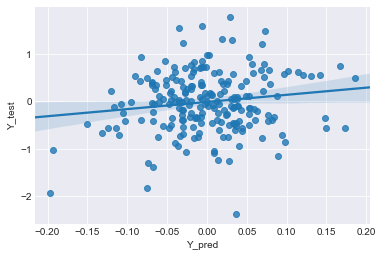

In [14]:
# 2017年のデータで予想し、グラフで予測具合を見る

Y_pred = linear_reg_model.predict(X_test) # 予測する

result = pd.DataFrame(Y_pred) # 予測
result.columns = ['Y_pred']
result['Y_test'] = Y_test

sns.set_style('darkgrid') 
sns.regplot(x='Y_pred', y='Y_test', data=result) #plotする


# 正答率を計算
success_num = 0
for i in range(len(Y_pred)):
    if Y_pred[i] * Y_test[i] >=0:
        success_num+=1

print("予測日数："+ str(len(Y_pred))+"、正答日数："+str(success_num)+"、正答率："+str(success_num/len(Y_pred)*100))

2017年の利益合計：0.245


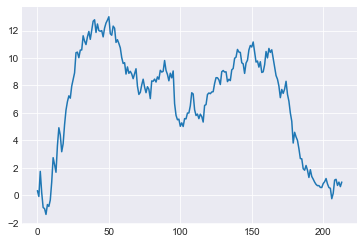

In [15]:
# 2017年の予測結果の合計を計算ーーーーーーーーー
# 前々日終値に比べて前日終値が高い場合は、買いとする
sum_2017 = 0

for i in range(0,len(Y_test)): # len()で要素数を取得しています
    if Y_pred[i] >= 0:
        sum_2017 += Y_test[i]
    else:
        sum_2017 -= Y_test[i]

print("2017年の利益合計：%1.3lf" %sum_2017) 


# 予測結果の総和グラフを描くーーーーーーーーー
total_return = np.zeros(len(Y_test))

if Y_pred[i] >=0: # 2017年の初日を格納
    total_return[0] = Y_test[i]
else:
    total_return[0] = -Y_test[i]

for i in range(1, len(result)): # 2017年の2日以降を格納
    if Y_pred[i] >=0:
        total_return[i] = total_return[i-1] + Y_test[i]
    else:
        total_return[i] = total_return[i-1] - Y_test[i]

plt.plot(total_return)


In [16]:
x = [10, 20, 30, 40, 50]
i=4
print(x[0:i])
print(x[i])

[10, 20, 30, 40]
50
